Importing data from computer

In [ ]:
!pip install tensorflow

In [1]:

import tensorflow as tf

images_train = tf.keras.preprocessing.image_dataset_from_directory(
    '../raw_data/image_train',
    image_size=(32, 32),
    shuffle=True,
    batch_size=32,
    label_mode='int',
    validation_split=0.2,
    subset='training',
    seed=50
)

NotFoundError: Could not find directory ../raw_data/image_train

In [94]:
images_val = tf.keras.preprocessing.image_dataset_from_directory(
    '../raw_data/image_train',
    image_size=(32, 32),
    shuffle=True,
    batch_size=32,
    label_mode='int',
    validation_split=0.2,
    subset='validation',
    seed=50
)

Found 100000 files belonging to 2 classes.
Using 20000 files for validation.


In [95]:
images_train.class_names

['FAKE', 'REAL']

In [96]:
images_test = tf.keras.preprocessing.image_dataset_from_directory(
    '../raw_data/image_test',
    image_size=(32, 32),
    shuffle=True,
    batch_size=32,
    label_mode='int'
)

Found 20000 files belonging to 2 classes.


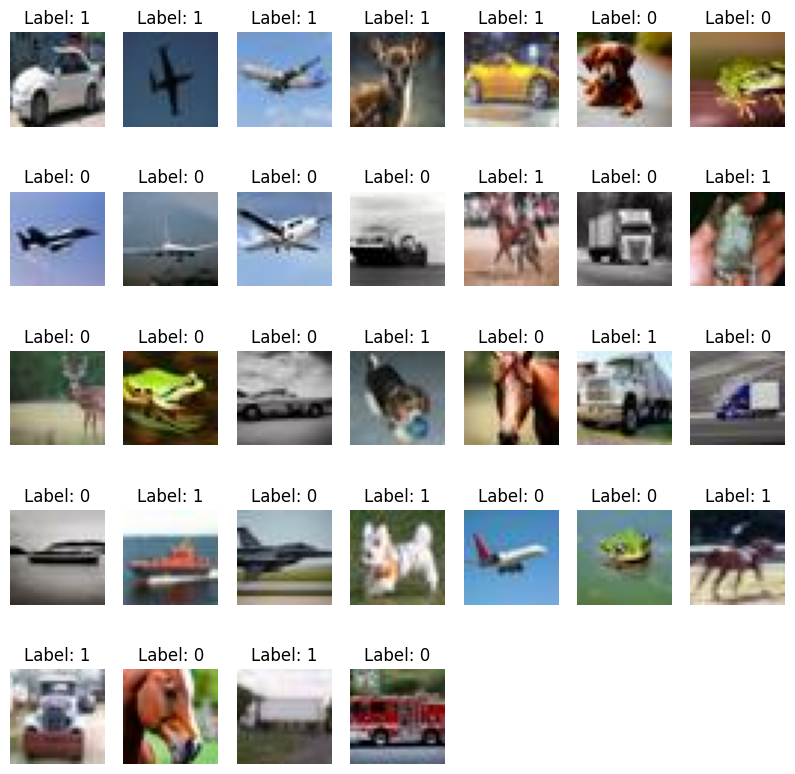

In [97]:
import matplotlib.pyplot as plt

for images, labels in images_train.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(32):
        ax = plt.subplot(5, 7, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

Scaling

In [98]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

def preprocess_images(image, label):
    image = preprocess_input(image)
    return image, label

images_train = images_train.map(preprocess_images)
images_val = images_val.map(preprocess_images)


Modeling


In [125]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor='val_loss',
    patience=1,
    restore_best_weights=True
)

base_model = MobileNetV2(input_shape=(32, 32, 3), classes=2, include_top=False)

/tmp/ipykernel_1242/3667886908.py:13: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(32, 32, 3), classes=2, include_top=False)


In [100]:
for layer in base_model.layers:
    layer.trainable = False

In [126]:
model = base_model.output

In [127]:
model = GlobalAveragePooling2D()(model)
model = Dense(1, activation='sigmoid')(model)

In [128]:
final_model = Model(inputs=base_model.input, outputs=model)

In [129]:
final_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [130]:
final_model.fit(images_train, epochs=10, batch_size=32, validation_data=images_val, callbacks=[es])

Epoch 1/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 398s 146ms/step - accuracy: 0.8342 - loss: 0.4109 - val_accuracy: 0.8030 - val_loss: 0.5567
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 295s 118ms/step - accuracy: 0.8785 - loss: 0.2984 - val_accuracy: 0.9151 - val_loss: 0.2745
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 267s 107ms/step - accuracy: 0.8292 - loss: 0.3949 - val_accuracy: 0.8090 - val_loss: 0.9136


In [131]:
predictions = final_model.predict(images_test)

625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step


In [132]:
import numpy as np

In [133]:
binary_predictions = np.where(predictions > 0.5, 1, 0).flatten()

true_labels = []
for _, labels in images_test:
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels).flatten()

accuracy = np.mean(binary_predictions == true_labels)

In [134]:
predictions

array([[0.7454941 ],
       [0.9938152 ],
       [0.75476676],
       ...,
       [0.99423933],
       [0.9959461 ],
       [0.9950086 ]], dtype=float32)

In [135]:
binary_predictions

array([1, 1, 1, ..., 1, 1, 1])

In [136]:
true_labels

array([0, 1, 1, ..., 0, 0, 1], dtype=int32)

In [137]:
accuracy

np.float64(0.50105)

In [138]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import numpy as np

def load_and_preprocess_image(image_path):

    image = load_img(image_path, target_size=(32,32))
    image = img_to_array(image)
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)

    return image

In [146]:
sheeps = load_and_preprocess_image('../raw_data/Sheep-front.jpg')

In [147]:
final_model.predict(sheeps)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


array([[0.00052413]], dtype=float32)

In [145]:
final_model.save('model.keras')